In [13]:
import pickle
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from matplotlib import pyplot as plt
import pandas as pd

Read saved serialized predictions (see 1vA.ipynb)

In [14]:
with open("results_1vA.pickle", 'rb') as f:
    results = pickle.load(f)
    
datasets = list(results.keys())
datasets

['ajt', 'chd', 'corpas', 'yri']

Compute overall accuracies over all datasets and methods

In [15]:
def accuracy(test, pred_type):
    return accuracy_score(results[test]['y_test'],
                          results[test][pred_type])

data = [[accuracy(test, pred_type) for pred_type in ["preds_naive", "preds_ci", "preds_lr", "preds_xgb"]] for test in datasets]

df = pd.DataFrame(data, columns=["No recal", "Confidence intervals", "Logistic regression", "XGBoost"])
df['Trio'] = ['chd', 'ajt', 'corpas', 'yri']
df[['Trio', 'No recal', "Confidence intervals", 'Logistic regression', 'XGBoost']]

,Trio,No recal,Confidence intervals,Logistic regression,XGBoost
0,chd,0.876236,0.968693,0.976120,0.986145
1,ajt,0.893423,0.925840,0.926561,0.941564
2,corpas,0.903020,0.947417,0.950572,0.962749
3,yri,0.875756,0.963037,0.973894,0.981122


Plot overall results

In [37]:
contaminations = sorted(list(results['ajt']['idx'].keys()))
pred_types = ['preds_naive',  'preds_ci', 'preds_lr', 'preds_xgb']
pred_names = {'preds_naive': "No recalibration",
              'preds_ci': "Confidence interval",
              'preds_lr': "Logistic regression",
              'preds_xgb': "XGBoost"}

metrics = [precision_score, recall_score, f1_score]
metric_names = ["precision", "recall", "f1"]
metric_desc = ["Precision score", "Recall score", "F1 score"]

scores = {}

for test in datasets:
    scores[test] = {}
    
    for pred_type in pred_types:
        scores[test][pred_type] = {}
        for metric, name in zip(metrics, metric_names):
            scores[test][pred_type][name] = []
            for contamination in contaminations:
                scores[test][pred_type][name].append(metric(results[test]['y_test'][results[test]['idx'][contamination]],
                                                            results[test][pred_type][results[test]['idx'][contamination]],
                                                            average='macro'))
        scores[test][pred_type]['accuracy'] = []
        for contamination in contaminations:
                scores[test][pred_type]['accuracy'].append(accuracy_score(results[test]['y_test'][results[test]['idx'][contamination]],
                                                            results[test][pred_type][results[test]['idx'][contamination]],))
metric_names.append('accuracy')

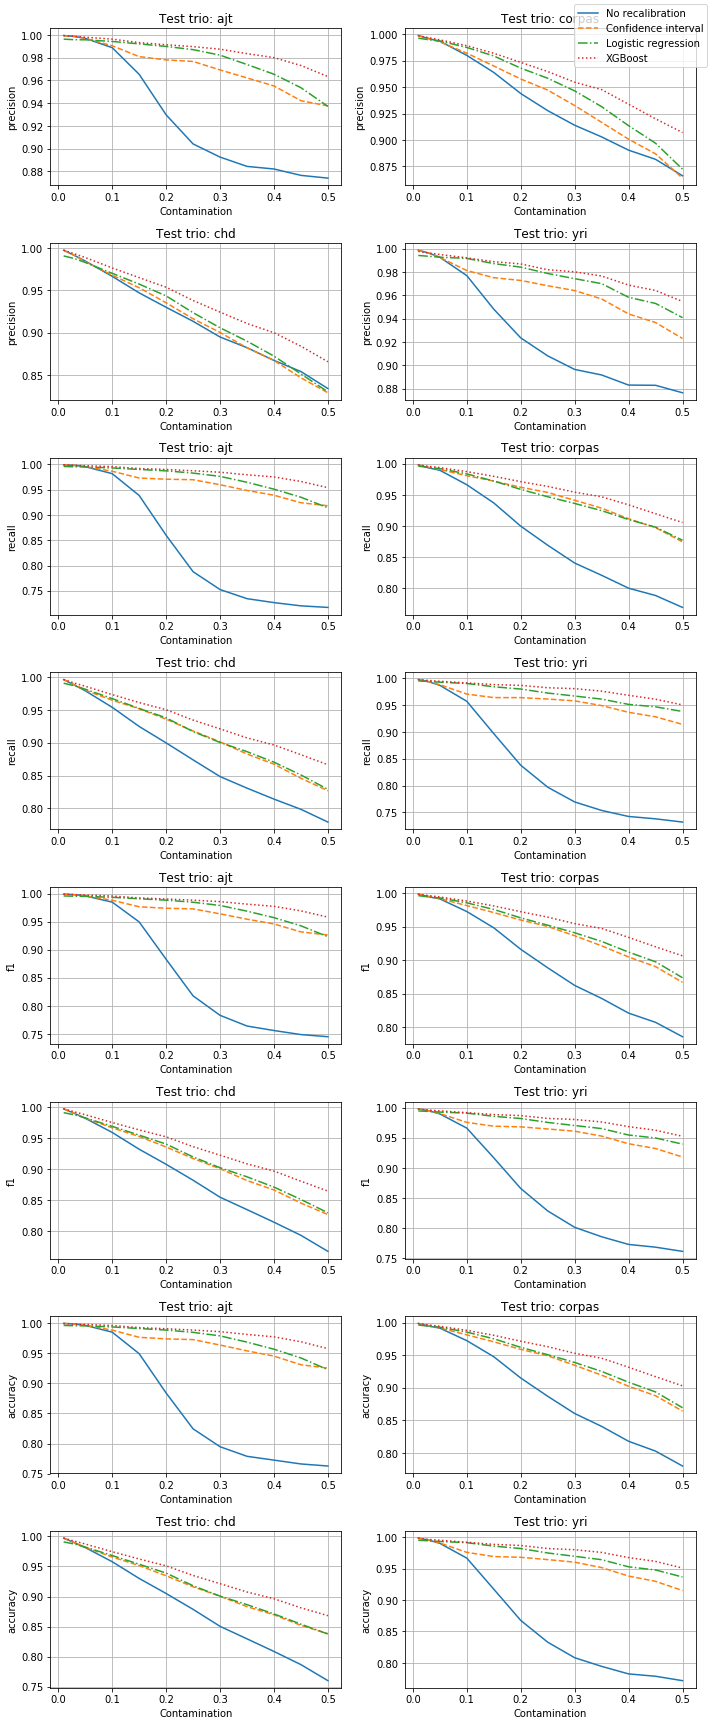

In [44]:
sp, ax = plt.subplots(8, 2, figsize=(10, 24))

linestyles = ['-', '--', '-.', ':']

for j, name in enumerate(metric_names):
    for i, test in enumerate(datasets):
        ax[j*2+i%2, i//2].set_title("Test trio: {}".format(test))

        for k, pred_type in enumerate(pred_types):
            ax[j*2+i%2,i//2].plot(contaminations, scores[test][pred_type][name], label=pred_names[pred_type], linestyle=linestyles[k])


        ax[j*2+i%2, i//2].grid()
        ax[j*2+i%2, i//2].set_xlabel("Contamination")
        ax[j*2+i%2, i//2].set_ylabel(name)

plt.tight_layout()
handles, labels = ax[1, 1].get_legend_handles_labels()
sp.legend(handles, labels, loc='upper right')

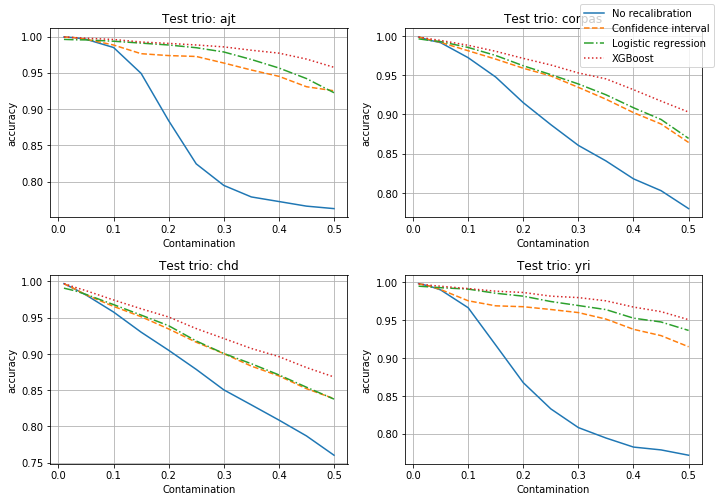

In [49]:
sp, ax = plt.subplots(2, 2, figsize=(10, 7))

linestyles = ['-', '--', '-.', ':']

name = 'accuracy'
for i, test in enumerate(datasets):
    ax[i%2, i//2].set_title("Test trio: {}".format(test))

    for k, pred_type in enumerate(pred_types):
        ax[i%2,i//2].plot(contaminations, scores[test][pred_type][name], label=pred_names[pred_type], linestyle=linestyles[k])


    ax[i%2, i//2].grid()
    ax[i%2, i//2].set_xlabel("Contamination")
    ax[i%2, i//2].set_ylabel(name)

plt.tight_layout()
handles, labels = ax[1, 1].get_legend_handles_labels()
sp.legend(handles, labels, loc='upper right')
sp.savefig('accuracies.eps', format='eps', dpi=1000)